# Wearable step counter

## Data import, filtering, and fixing

### import

In [60]:
import pandas as pd
import openpyxl

# get the step counter data from the data file
data_file: str = './resources/femaleWalk.xlsx'
walk_df = pd.read_excel(data_file)
display(walk_df.head())
display(walk_df.tail())

# final row in data file says "finish Activity Duration : 2 minutes12seconds"
# 132s, 50Hz --> 6600 data points. But there are 8320 records in the dataset, so the actual data
# says 8321 data points (zero indexed minus summary line), 132s --> 63.03787879Hz --> 63.0Hz

,accdatax,accdatay,accdataz,magdatax,magdatay,magdataz,gyrodatax,gyrodatay,gyrodataz,lightdatax
0,-3.154818,0.445217,8.612317,-1.7690,-38.3690,-25.772501,0.069248,-0.154476,0.015980,1824.0
1,-3.154818,0.445217,8.612317,1.1895,-42.5475,-25.772501,0.063921,-0.138495,0.029297,1824.0
2,-3.154818,0.445217,8.612317,1.1895,-42.5475,-25.772501,0.045277,-0.098545,0.058594,1824.0
3,-3.308011,0.847349,8.459125,1.1895,-42.5475,-25.772501,0.047941,-0.074574,0.069248,1824.0
4,-3.308011,0.847349,8.459125,1.1895,-42.5475,-25.772501,0.037287,-0.031960,0.079901,1824.0


,accdatax,accdatay,accdataz,magdatax,magdatay,magdataz,gyrodatax,gyrodatay,gyrodataz,lightdatax
8317,-3.240989,3.001625,7.836778,29.9815,-23.3630,-15.5855,0.221060,0.000000,0.005327,1068.0
8318,-3.240989,3.001625,7.836778,26.9620,-26.3825,-19.1845,0.306288,0.013317,-0.010653,1068.0
8319,-3.260138,2.676090,8.468699,26.9620,-26.3825,-19.1845,0.340912,0.010653,-0.026634,1068.0
8320,-3.260138,2.676090,8.468699,26.9620,-26.3825,-19.1845,0.221060,-0.007990,-0.047941,1068.0
8321,finish Activity Duration : 2 minutes12seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### fixing and filtering

In [61]:
# check data types
from numpy import float64
from pydantic import BaseModel, FiniteFloat

# we only need the accelerometer data from the 3 axes, so...
walk_df = walk_df[['accdatax', 'accdatay', 'accdataz']]
# remove the summary row
walk_df = walk_df.iloc[:-1]
# show dtypes
# print(walk_df.dtypes)
# convert the accdatax column to float
walk_df['accdatax'] = walk_df['accdatax'].astype('float64')
print(walk_df.dtypes)

display(walk_df.head())
display(walk_df.tail())

class AccData(BaseModel):
    accdatax: FiniteFloat # invalidates inf, -inf, and nan
    accdatay: FiniteFloat
    accdataz: FiniteFloat

for index, row in walk_df.iterrows():
    try:
        AccData(**row.to_dict())
    except Exception as e:
        print(e)


accdatax    float64
accdatay    float64
accdataz    float64
dtype: object


,accdatax,accdatay,accdataz
0,-3.154818,0.445217,8.612317
1,-3.154818,0.445217,8.612317
2,-3.154818,0.445217,8.612317
3,-3.308011,0.847349,8.459125
4,-3.308011,0.847349,8.459125


,accdatax,accdatay,accdataz
8316,-3.240989,3.001625,7.836778
8317,-3.240989,3.001625,7.836778
8318,-3.240989,3.001625,7.836778
8319,-3.260138,2.676090,8.468699
8320,-3.260138,2.676090,8.468699


### display data on one plot

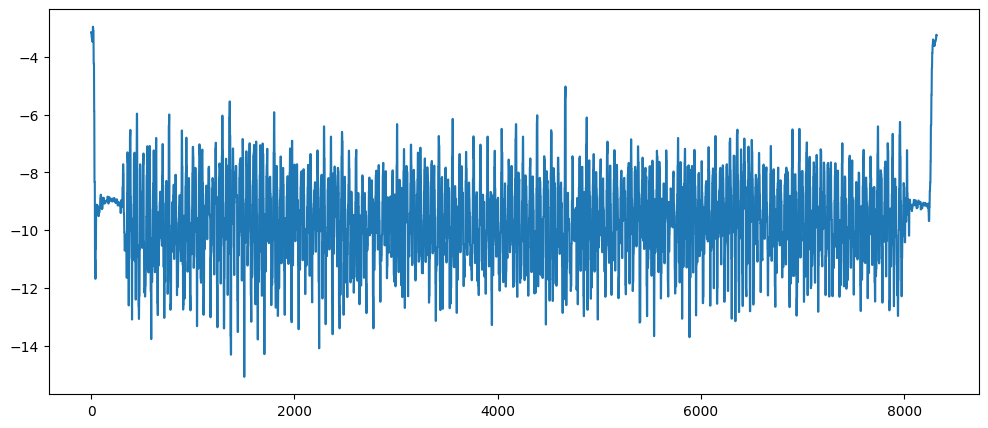

In [62]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

x_df = walk_df['accdatax']
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
# plt.figure(figsize=(12, 8))
# ax[0,0].plot(x_df)
ax.plot(x_df)
plt.show()


There seems to be some beginning and ending event in the data, separate from the walking pattern (perhaps an act of getting up and sitting down, or switch bounce in the measurement device), so we'll use a sample from the middle of the dataset...

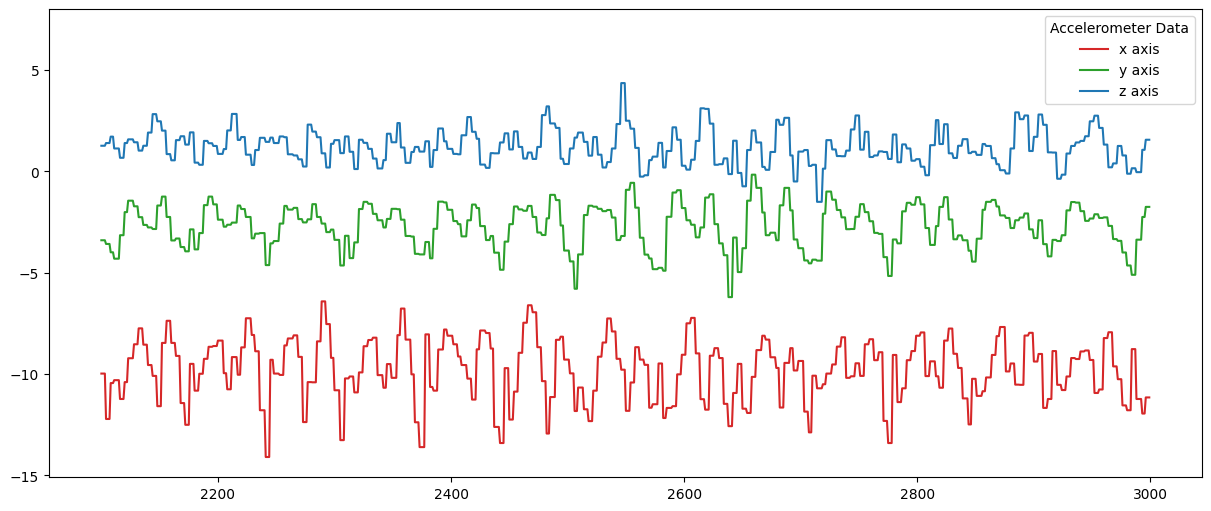

In [63]:
import matplotlib.colors as mcolors

walk_sample_df = walk_df.iloc[2100:3000]

# x_color = "red"
x_color = mcolors.TABLEAU_COLORS["tab:red"]
y_color = mcolors.TABLEAU_COLORS["tab:green"]
z_color = mcolors.TABLEAU_COLORS["tab:blue"]

x_sample_df = walk_sample_df['accdatax']
y_sample_df = walk_sample_df['accdatay']
z_sample_df = walk_sample_df['accdataz']
sample_index = walk_sample_df.index
fig, ax = plt.subplots(1, 1, figsize=(12, 5), constrained_layout=True)
ax.plot(sample_index, x_sample_df, label='x axis', color=x_color)
ax.plot(sample_index, y_sample_df, label='y axis', color=y_color)
ax.plot(sample_index, z_sample_df, label='z axis', color=z_color)
min_y: float = min(x_sample_df.min(), y_sample_df.min(), z_sample_df.min()) - 1.0
ax.set_ylim(bottom=min_y, top=8.0)
ax.legend(title='Accelerometer Data', loc='upper right')
plt.show()

There appears to be a base signal for each of the accelerometers plus some jitter.
We'll perform a fast Fourier transform on each signal in order to determine how best to filter out the higher-frequency (lower amplitude) jitter.

For the FFT sampling frequency, we make use of Nyquist Theorem:
$$f_{Nyquist} = F_s/2$$
Where $F_s$ is the sampling frequency of the source data, and $f_{Nyquist}$ is the maximum frequency up to which the signal can be represented (if there were frequencies higher than this in the behaviour being detected by the accelerometer, they will not be represented in the data, and a Fourier transform cannot accurately represent them).

The FFT will produce a frequency spectrum from $-F_s/2$ to $F_s/2$, and we'll take the real (positive) values only, so 0Hz to $(F_s/2)$Hz

So if we use an FFT sampling frequency of 50Hz (matching the data sampling frequency), we'll get the most accurate representation.

sample count: 900
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38]


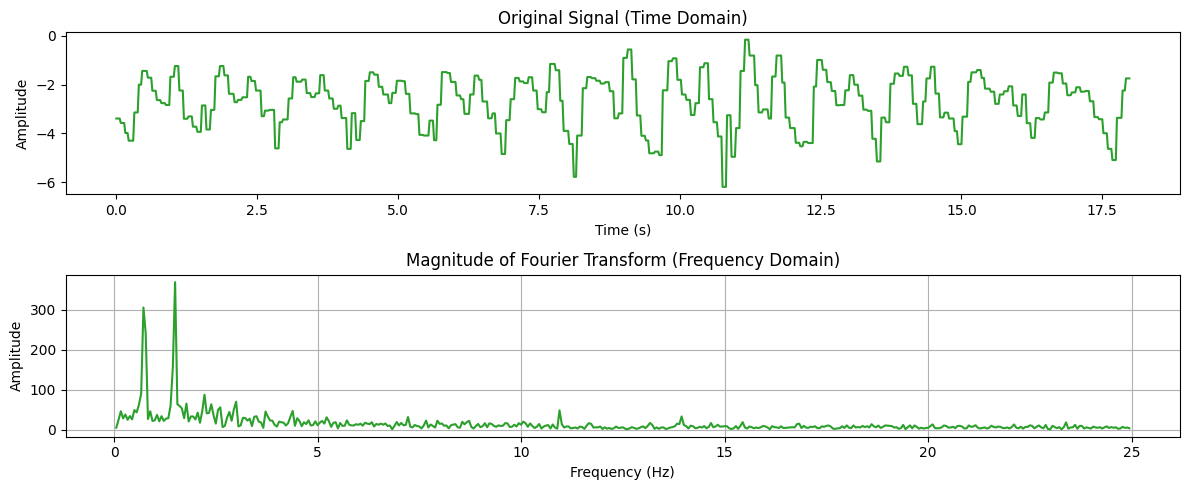

In [64]:
import numpy as np

# we'll choose an FFT sampling frequency matching the source sample frequency
fft_sample_freq = 50
fft_sample_interval = 1 / fft_sample_freq
# we need time data for the independent axis (in place of sample index)
# well trust the datasheet and take the sampling rate to be 50Hz
# so each sample index maps to a time delta of (1/50)s
sample_count = len(walk_sample_df)
print(f"sample count: {sample_count}")
time_series = np.arange(0, sample_count / 50, 1 / 50)
print(time_series[:20])
fft_y = np.fft.fft(y_sample_df)
fft_y_freq = np.fft.fftfreq(len(time_series), fft_sample_interval)
fft_magnitude = np.abs(fft_y)

positive_freq_indices = fft_y_freq > 0
fft_y_freq = fft_y_freq[positive_freq_indices]
fft_magnitude = fft_magnitude[positive_freq_indices]

plt.figure(figsize=(12, 5))

plt.subplot(2,1, 1)
plt.plot(time_series, y_sample_df, label='y axis', color=y_color)
plt.title("Original Signal (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2,1,2)
plt.plot(fft_y_freq, fft_magnitude, color=y_color)
plt.title("Magnitude of Fourier Transform (Frequency Domain)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

# TODO: apply a moving average filter OR filter out all but the two largest frequencies indicated in the FFT.

# A Google search for "numpy bandpass filter" leads us to
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html



Let's zoom in on those primary frequencies in the Fourier transform, so we can choose a high and low cutoff for the bandpass filter

For the FFT sampling

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38]


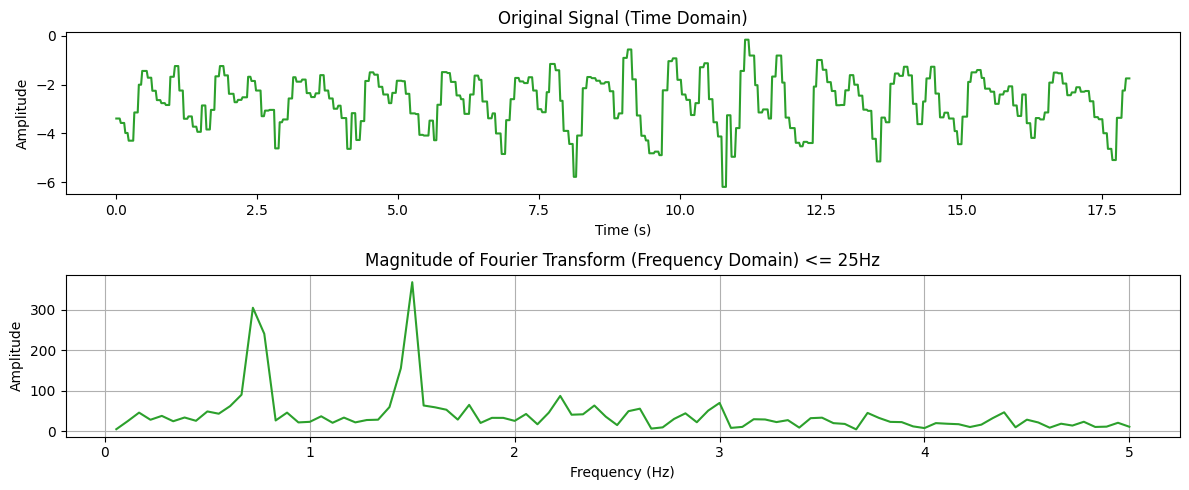

In [65]:
from numpy import ndarray

# show a smaller range of frequency values for the second plot

# we'll choose a sampling frequency for the FFT that's the same as the sampling
# frequency for the source data. See Nyquist Theorem and FFT behaviour
fft_sample_freq = 50
fft_sample_interval = 1 / fft_sample_freq
# we need time data for the independent axis (in place of sample index)
# well trust the datasheet and take the sampling rate to be 50Hz
# so each sample index maps to a time delta of (1/50)s
time_series = np.arange(0, sample_count / 50, 1 / 50)
print(time_series[:20])
fft_y = np.fft.fft(y_sample_df)
# fft_y_freq = np.fft.fftfreq(len(time_series), fft_sample_interval)
fft_y_freq: ndarray = np.fft.fftfreq(len(time_series), fft_sample_interval)
fft_magnitude: ndarray = np.abs(fft_y)

positive_freq_indices = fft_y_freq > 0
fft_y_freq = fft_y_freq[positive_freq_indices]
fft_magnitude = fft_magnitude[positive_freq_indices]

# keep a range of frequencies for the independent axis
freq_range_indices = fft_y_freq <= 5
filtered_y_freq: ndarray = fft_y_freq[freq_range_indices]
filtered_magnitude: ndarray = fft_magnitude[freq_range_indices]

plt.figure(figsize=(12, 5))

plt.subplot(2,1,1)
plt.plot(time_series, y_sample_df, label='y axis', color=y_color)
plt.title("Original Signal (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2,1,2)
plt.plot(filtered_y_freq, filtered_magnitude, color=y_color)
plt.title("Magnitude of Fourier Transform (Frequency Domain) <= 25Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

# A Google search for "numpy bandpass filter" leads us to
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html


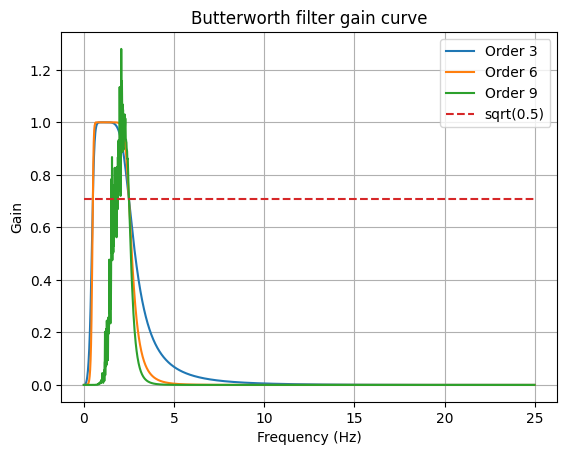

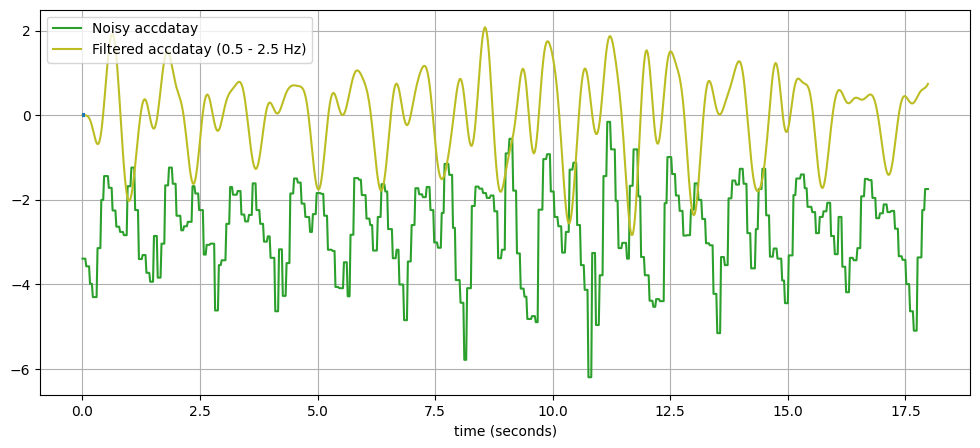

In [66]:
from scipy.signal import butter, lfilter, freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

fs = 50
# NOTE: if we filter out the higher of these two primary frequencies, we get a signal without a
# consistent amplitude (unusable). If we filter out the lower, we get a smooth signal at a
# higher frequency than the step frequency appears to be. It seems that the signal pattern
# for a step from the y axis data is a combination of these two frequencies. Letting both of these
# frequencies pass is the only way to get the gait signal without the noise.

lowcut = 0.5
# lowcut = 1.25
# highcut = 1.0
# highcut = 1.75
highcut = 2.5

x_color_2 = mcolors.TABLEAU_COLORS["tab:pink"]
y_color_2 = mcolors.TABLEAU_COLORS["tab:olive"]
z_color_2 = mcolors.TABLEAU_COLORS["tab:cyan"]

plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label='Order %d' % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Butterworth filter gain curve')
plt.grid(True)
plt.legend(loc='best')

# Filter a noisy signal.
T = 0.05
nsamples = int(T * fs)
t = np.linspace(0, T, nsamples, endpoint=False)
a = 0.02
f0 = 600.0
x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
x += a * np.cos(2 * np.pi * f0 * t + .11)
x += 0.03 * np.cos(2 * np.pi * 2000 * t)

plt.figure(2, figsize=(12, 5))
plt.clf()
plt.plot(time_series, y_sample_df, label='Noisy accdatay', color=y_color)

# y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
y = butter_bandpass_filter(y_sample_df, lowcut, highcut, fs, order=6)
plt.plot(time_series, y, label=f"Filtered accdatay ({lowcut} - {highcut} Hz)", color=y_color_2)
plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

It looks like there are peaks near .75Hz and 1.5Hz, so let's use .5Hz and 1.75Hz as the cutoff frequencies (we're eyeballing it here – if required we could set an amplitude threshold and filter out any frequencies that don't reach that value on the frequency domain plot)

Let's repeat this for the x and z data

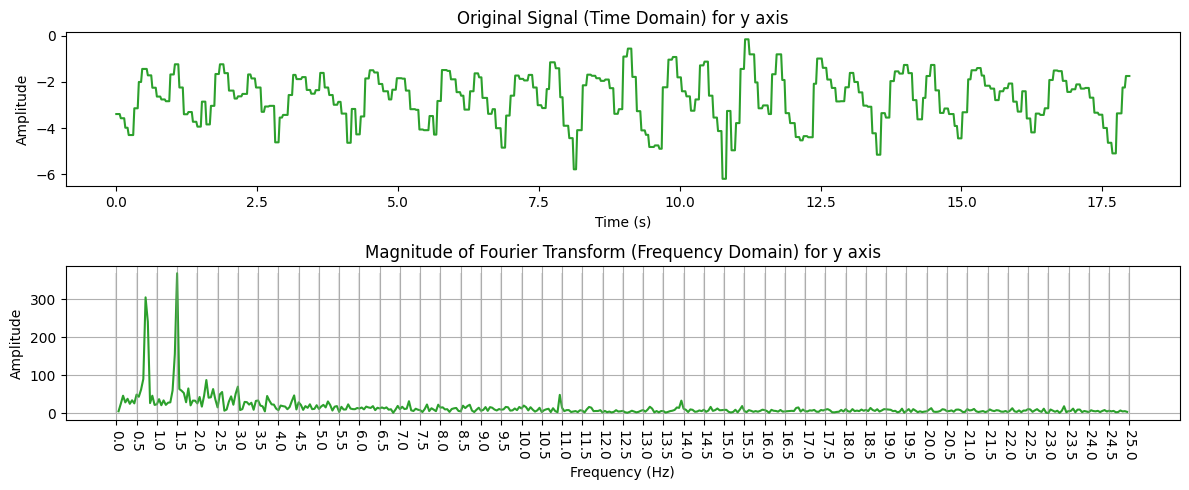

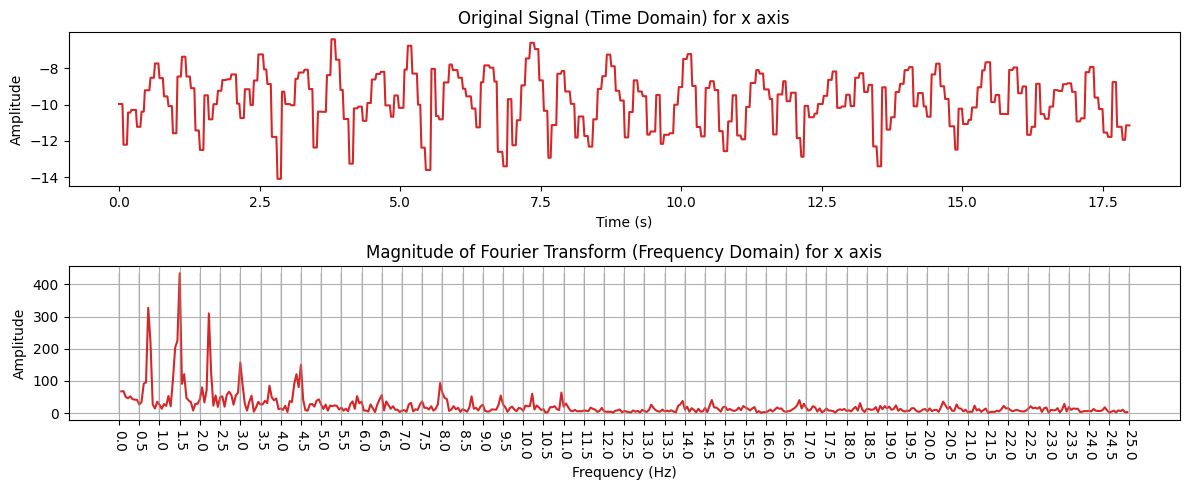

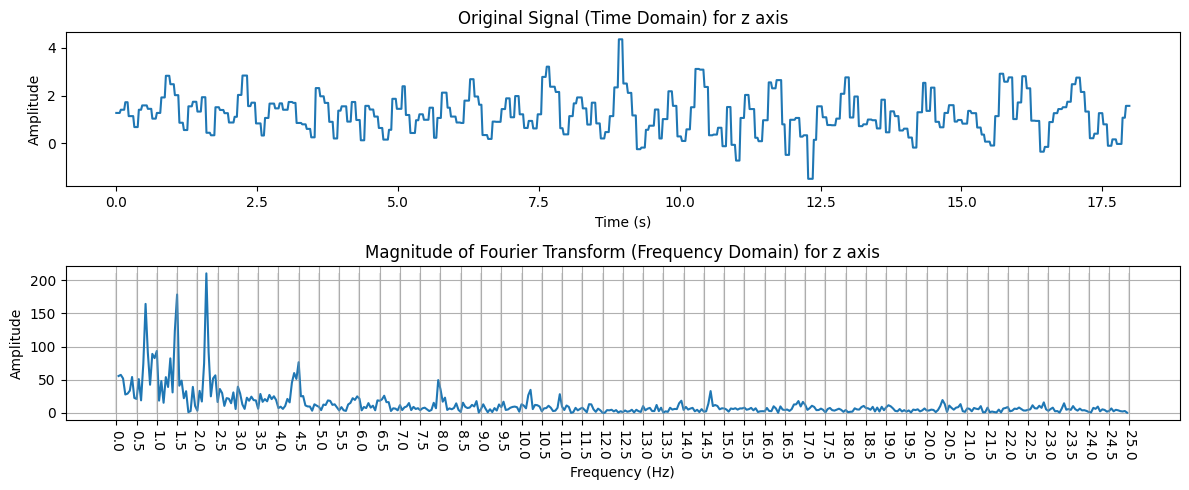

In [67]:
import numpy as np

def fft_plots(fft_sample_freq: int, data_series: ndarray, series_label: str, series_color, grid_color):
    fft_sample_interval = 1 / fft_sample_freq
    sample_count = len(data_series)
    time_series = np.arange(0, sample_count / fft_sample_freq, 1 / fft_sample_freq)
    fft_result = np.fft.fft(data_series)
    fft_result_freq = np.fft.fftfreq(len(time_series), fft_sample_interval)
    fft_magnitude = np.abs(fft_result)

    positive_freq_indices = fft_result_freq > 0
    fft_result_freq = fft_result_freq[positive_freq_indices]
    fft_magnitude = fft_magnitude[positive_freq_indices]
    plt.figure(figsize=(12, 5))
    plt.subplot(2,1, 1)
    plt.plot(time_series, data_series, label=series_label, color=series_color)
    plt.title(f"Original Signal (Time Domain) for {series_label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.subplot(2,1,2)
    plt.plot(fft_result_freq, fft_magnitude, color=series_color)
    plt.title(f"Magnitude of Fourier Transform (Frequency Domain) for {series_label}")
    interval = 0.5
    xtick_positions = np.arange(0, max(fft_result_freq) + interval, interval)
    plt.xticks(xtick_positions, rotation=-90)
    plt.vlines(x=xtick_positions, ymin=min(fft_magnitude), ymax=max(fft_magnitude), color=grid_color, linestyles='-', alpha=0.3)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()

    plt.tight_layout()
    plt.show()

fft_plots(50, y_sample_df, "y axis", y_color, "darkgrey")
fft_plots(50, x_sample_df, "x axis", x_color, "darkgrey")
fft_plots(50, z_sample_df, "z axis", z_color, "darkgrey")



It appears as though the other axes have slightly different frequency characteristics (which makes sense, since
the accelerometer data will be measuring the result of various component movements of body parts during walking,
with different amplitudes in each axis.

Also, look at the noise in z around 4.5Hz. That's maybe consistent noise from a physical vibration? Or something to do with the forearm movement while walking?

Note that there's a spike around 4.5Hz for both z and x, but not for y. Also z and x have 3 base frequencies, while y has 2. Is y actually the data for the accelerometer normal to the watch face?

We might consider adjusting the phase of one or two of the signals if we're going to use a sum.

Let's perform the smoothing for the other two axes.

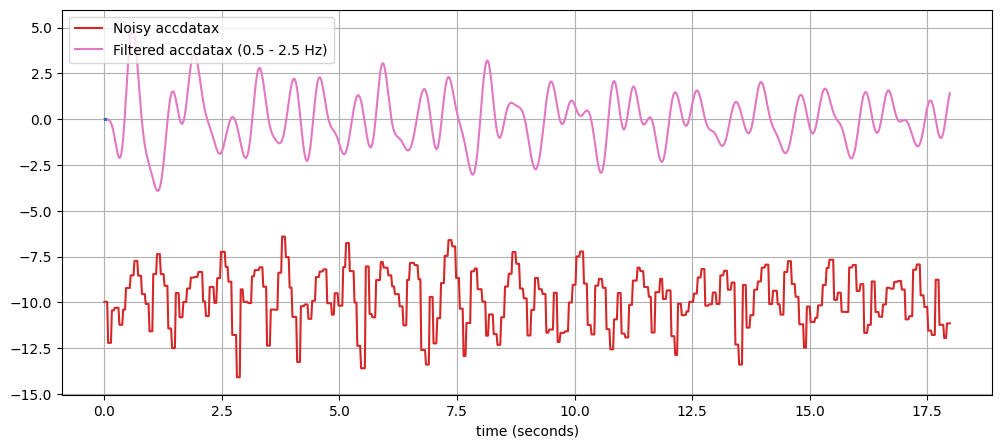

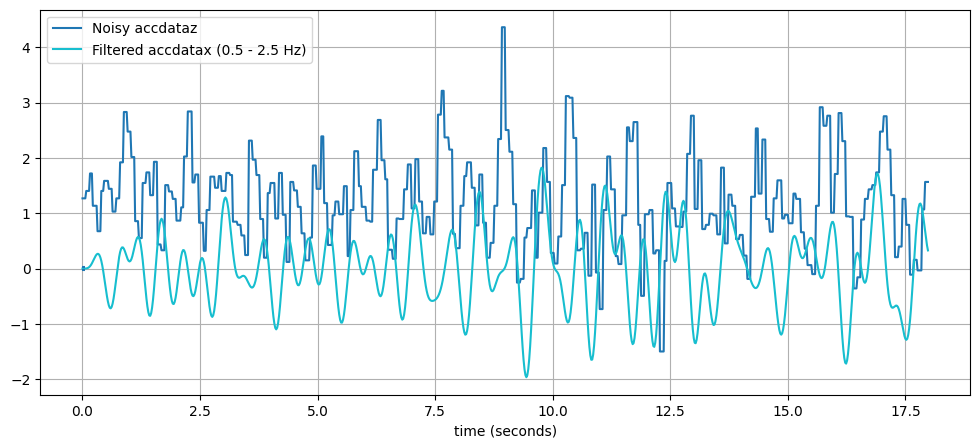

In [68]:
# TODO: perform the smoothing for the other axes
# NOTE: consider using a bandpass that's the same for all 3 axes, since we
#  expect the gait to have the same bandwidth in all 3 axes.
#  0.5Hz to 2.5 Hz looks like it should work.
#  If we really wanted to go nuts, we could plot all 3 FFT plots on the same figure
#  and look at their overlap. But that's out of scope.
# TODO: create a signal that is the sum of the three smoothed signals
# TODO: count the steps based on the shape of the combined signal (count the
#  minima, count the maxima, or count the mean crossings.

# from scipy.signal import butter, lfilter, freqz
#
# def butter_bandpass(lowcut, highcut, fs, order=5):
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = butter(order, [low, high], btype='band')
#     return b, a
#
# def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = lfilter(b, a, data)
#     return y

fs = 50
# NOTE: if we filter out the higher of these two primary frequencies, we get a signal without a
# consistent amplitude (unusable). If we filter out the lower, we get a smooth signal at a
# higher frequency than the step frequency appears to be. It seems that the signal pattern
# for a step from the y axis data is a combination of these two frequencies. Letting both of these
# frequencies pass is the only way to get the gait signal without the noise.

lowcut = 0.5
# lowcut = 1.25
# highcut = 1.0
# highcut = 1.75
highcut = 2.5

# plt.figure(2)
# plt.clf()
# for order in [3, 6, 9]:
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     w, h = freqz(b, a, worN=2000)
#     plt.plot((fs * 0.5 / np.pi) * w, abs(h), label='Order %d' % order)

# plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Gain')
# plt.title('Butterworth filter gain curve')
# plt.grid(True)
# plt.legend(loc='best')

# Filter a noisy signal.
T = 0.05
# nsamples = int(T * fs)
# t = np.linspace(0, T, nsamples, endpoint=False)
a = 0.02
# f0 = 600.0
# x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
# x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
# x += a * np.cos(2 * np.pi * f0 * t + .11)
# x += 0.03 * np.cos(2 * np.pi * 2000 * t)

plt.figure(3, figsize=(12, 5))
plt.clf()
plt.plot(time_series, x_sample_df, label='Noisy accdatax', color=x_color)

# y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
x = butter_bandpass_filter(x_sample_df, lowcut, highcut, fs, order=6)
plt.plot(time_series, x, label=f"Filtered accdatax ({lowcut} - {highcut} Hz)", color=x_color_2)
plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

# plt.show()

plt.figure(4, figsize=(12, 5))
plt.clf()
plt.plot(time_series, z_sample_df, label='Noisy accdataz', color=z_color)
z = butter_bandpass_filter(z_sample_df, lowcut, highcut, fs, order=6)
plt.plot(time_series, z, label=f"Filtered accdatax ({lowcut} - {highcut} Hz)", color=z_color_2)
plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()


Now we'll take a sum of the smoothed seria

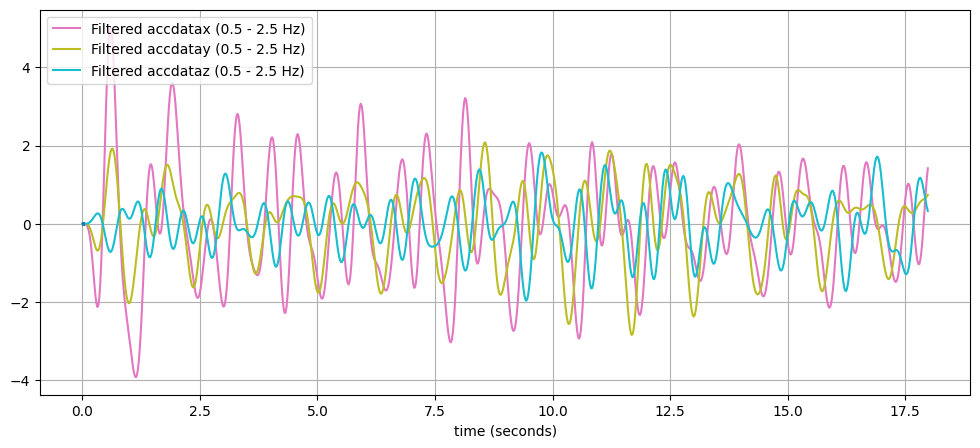

In [69]:
plt.figure(5, figsize=(12, 5))
plt.plot(time_series, x, label=f"Filtered accdatax ({lowcut} - {highcut} Hz)", color=x_color_2)
plt.plot(time_series, y, label=f"Filtered accdatay ({lowcut} - {highcut} Hz)", color=y_color_2)
plt.plot(time_series, z, label=f"Filtered accdataz ({lowcut} - {highcut} Hz)", color=z_color_2)

plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

Before summing let's normalize the amplitudes, since we care about the patterns in the signal from each axis,

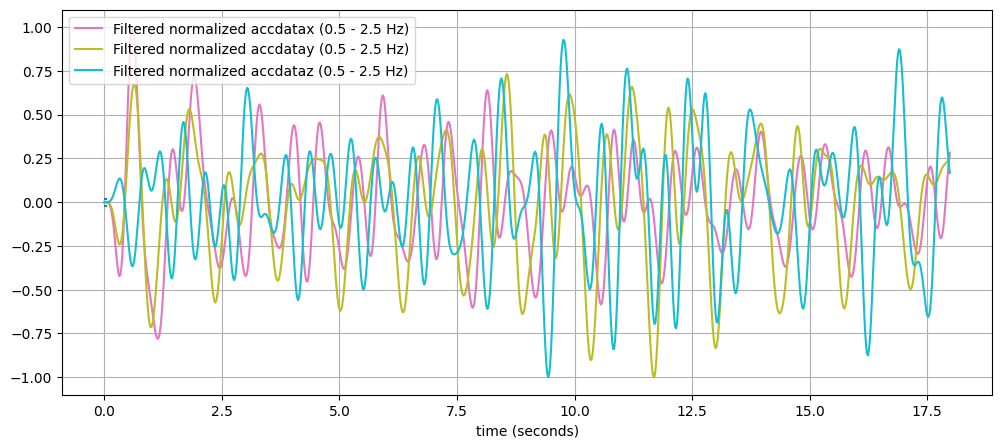

In [70]:
x_normalized = x / np.max(np.abs(x))
y_normalized = y / np.max(np.abs(y))
z_normalized = z / np.max(np.abs(z))

plt.figure(6, figsize=(12, 5))
plt.plot(time_series, x_normalized, label=f"Filtered normalized accdatax ({lowcut} - {highcut} Hz)", color=x_color_2)
plt.plot(time_series, y_normalized, label=f"Filtered normalized accdatay ({lowcut} - {highcut} Hz)", color=y_color_2)
plt.plot(time_series, z_normalized, label=f"Filtered normalized accdataz ({lowcut} - {highcut} Hz)", color=z_color_2)

plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

Now let's sum the normalized signals

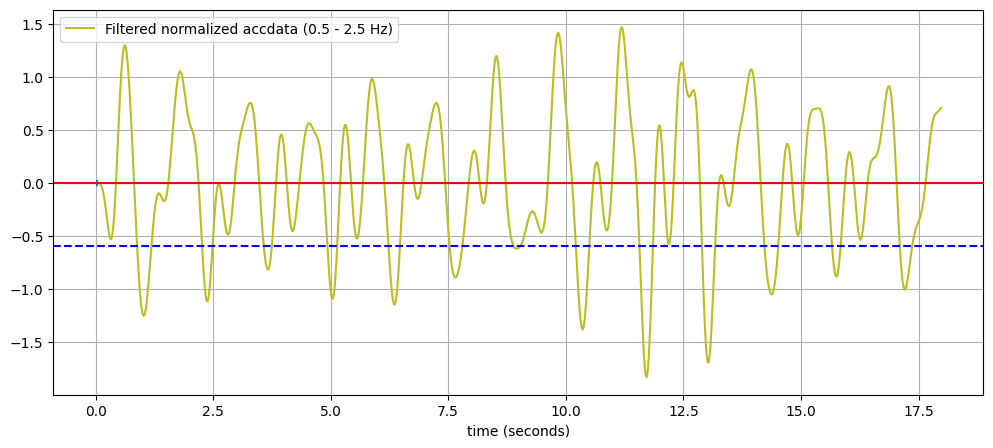

In [71]:
acc_sum = x_normalized + y_normalized + z_normalized
plt.figure(7, figsize=(12, 5))
plt.plot(time_series, acc_sum, label=f"Filtered normalized accdata ({lowcut} - {highcut} Hz)", color=y_color_2)

plt.axhline(y = acc_sum.mean(), color='r', linestyle='-')
cycle_cross_height = -0.595
plt.axhline(y = cycle_cross_height, color='blue', linestyle='--')

plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

I've drawn a horizontal line at the mean of the signal amplitude, and another further down. There appears to be a cyclical pattern in the combined signal, which is what we're looking for if we want to identify a pattern representing walking.

The blue horizontal line has been placed in order to intersect with the signal line twice (one with slope up and one with slope down) per cycle. There's likely a way to automate this, but I've done it by hand for now.

mean crossing count is 45
cycle crossing count is 26


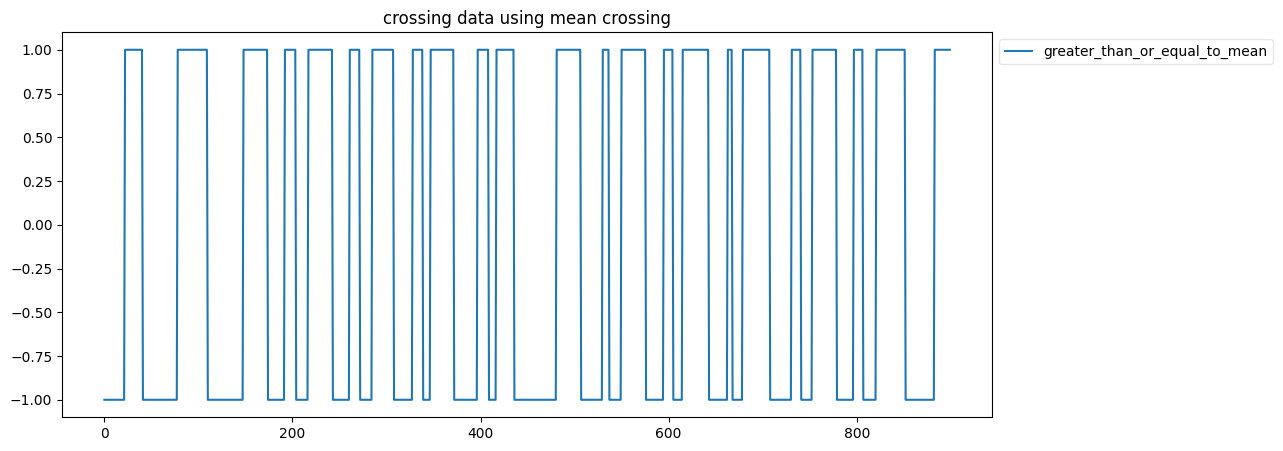

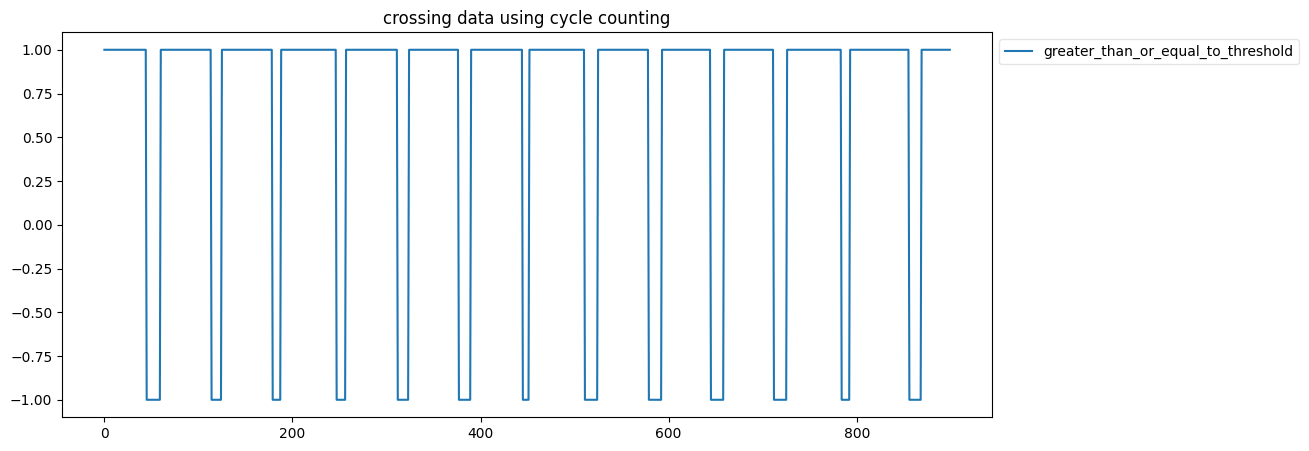

In [73]:
# Mean crossing

mean_crossing = acc_sum.copy()
mean_crossing = pd.DataFrame(mean_crossing)
# display(crossing)
# create a dataframe showing if the mapped value is greater than or equal to the mean value (results in a column of boolean values)
result = mean_crossing.ge(mean_crossing.mean())
result.columns = ['greater_than_or_equal_to_mean']
# display(result)
# print(result.iloc[0].dtypes)
# convert the dtype to something that can be converted to int
# result.iloc[:, 0] = result.iloc[:, 0].apply(lambda x: int(x))
# result.iloc[:, 0] = result.iloc[:, 0].astype(int)

# NOTE: we need to add a column name (and not just use .iloc) because of the way pandas handles dtype conversions. Using .iloc with .astype results in a warning.
result['greater_than_or_equal_to_mean'] = result['greater_than_or_equal_to_mean'].astype(int).replace({0:-1})
# result.iloc[:, 0] = result.iloc[:, 0].replace({True: 1, False: -1}).astype(int)
# result.iloc[:, 0] = result.iloc[:, 0].replace({0: -1}).astype(int)
# display(result)
# result.iloc[:, 0] =
result.plot(figsize=(12, 5))
plt.title("crossing data using mean crossing")
plt.legend(loc='upper left', framealpha=0.5, bbox_to_anchor=(1, 1))

meanCrossingCount = np.where(np.diff(np.sign(result.to_numpy().reshape(-1))))[0]

print(f"mean crossing count is {len(meanCrossingCount)}")

# cycle crossing count

cycle_crossing = acc_sum.copy()
cycle_crossing = pd.DataFrame(cycle_crossing)
result2 = cycle_crossing.ge(cycle_cross_height)
result2.columns = ['greater_than_or_equal_to_threshold']
result2['greater_than_or_equal_to_threshold'] = result2[['greater_than_or_equal_to_threshold']].astype(int).replace({0:-1})
result2.plot(figsize=(12, 5))
plt.title("crossing data using cycle counting")
plt.legend(loc='upper left', framealpha=0.5, bbox_to_anchor=(1, 1))

cycleCrossingCount = np.where(np.diff(np.sign(result2.to_numpy().reshape(-1))))[0]
print(f"cycle crossing count is {len(cycleCrossingCount)}")


Identifying this repeating cycle in the signal and assuming that's the walking gait results in a more evenly-spaced set of "crosses", which is what we expect if we're looking for a signal that will represent a walking gait with a consistent speed.

Using known step counts and taking samples in this way from different parts of the data, we could calculate a regression line for predicting step count from accelerometer data. The line would have a different equation from the one used with the "moving average and mean crossing" technique.

For the processed signal above, there are 13 steps (26 / 2) for each foot in 900 samples or 18 seconds (at 50Hz sampling rate), or **26 steps total**.

In a quick experiment, a very slow walking pace for me is about **23 steps** in 18 seconds, so this result seems reasonable.

Note that if we use 63Hz for the sampling rate (implied by the data rather than the specs for the device), we get **26 steps in 14 seconds**.

A normal walking pace for me is about **24 steps in 14 seconds**, so I'm inclined to believe the sampling rate is closer to 63Hz (though I don't know about the stride of the subjects from which the walking data came)